# Running HMETS using NRCAN forcing data

Here we use birdy's WPS client to launch the HMETS hydrological model on the server and analyze the output. We also prepare NRCAN daily data for Canadian catchments.

In [1]:
from birdy import WPSClient

from example_data import TESTDATA
import datetime as dt
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import netCDF4 as nc
import salem
from zipfile import ZipFile
import glob
import tempfile


# Set environment variable RAVEN_WPS_URL to "http://localhost:9099" to run on the default local server
#url = os.environ.get("RAVEN_WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")

# THIS CHANGED TO REFLECT MASTER, NOT LATEST RELEASE!
url="http://localhost:9099" 

wps = WPSClient(url)

In [16]:
# SETUP THE RUN PARAMETERS, for now only the start and end years of the simulation, the rest is hard-coded to 
# the Salmon-river example

startYear=2007 # Year of the beginning of the simulation
endYear=2008 # Year of the end of the simulation

# The shapefile of the catchment to model using ERA5 data. All files (.shp, .shx, etc.) must be zipped into one file.
#vec='/home/ets/src/raven/raven/tests/testdata/watershed_vector/Basin_test.zip'
vec='/home/ets/src/raven/raven/tests/testdata/watershed_vector/LSJ_LL.zip'

# Choose a dataset to use. We have 'NRCAN' and 'ERA5' for now. NRCAN is only available in Canada, ERA5 is global.
dataset='ERA5' 

# Choose a hydrological model to use. We have 'HMETS', 'GR4JCN','MOHYSE' and 'HBVEC'.
hydromodel = 'GR4JCN'

# Here is where we will write the NetCDF path for input data. Default is current working directory
dirpath = os.getcwd()



In [3]:
# We will first need to process the catchment boundaries from the zipped shapefile. This is boilerplate.
temppath=tempfile.mkdtemp()
ZipFile(vec,'r').extractall(temppath)
gg=glob.glob(temppath + '/*.shp')
shdf=salem.read_shapefile(gg[0])
shdf.crs=salem.wgs84
lon_min=shdf['min_x'][0]
lon_max=shdf['max_x'][0]
lat_min=shdf['min_y'][0]
lat_max=shdf['max_y'][0]

In [4]:
# From the shapefile, call the PAVICS-Hydro service to extract properties such as centroid lat/long, elevation and area.
resp = wps.shape_properties(shape=vec) 
[properties, ]=resp.get(asobj=True)
prop = properties[0]
basin_area = prop['area']/1000000.0
basin_longitude = prop['centroid'][0]
basin_latitude = prop['centroid'][1]
resp = wps.terrain_analysis(shape=vec, select_all_touching=True, projected_crs=3978)
properties, dem = resp.get(asobj=True)
basin_elevation=properties[0]['elevation']
print(basin_area)
print(basin_elevation)
print(basin_longitude)
print(basin_latitude)

44877.1880529685
404.70766683028666
-72.69128332186322
49.50119363123194


In [5]:
#import geopandas as gdp
#import regionmask
#import matplotlib.pyplot as plt
#nuts=gdp.read_file(gg[0])
#print(nuts.geometry.values[0])
#mask_poly=regionmask.Regions(outlines=nuts.geometry.values[0])
#print(mask_poly)
#mask = mask_poly.mask(tasYear.isel(time=0),lat_name='latitude',lon_name='longitude')
#print(mask)
#plt.figure(figsize=(12,8))
#ax=plt.axes()
#mask.plot(ax=ax)
#nuts.plot(ax=ax,alpha=0.8,facecolor='none', lw=1)

In [6]:
firstYear=str(startYear)

# Prepare data according to the NRCAN dataset. This entire section is boilerplate and should be left as is.
# Only change the controls above for the start and end time of the dataset download to fit the simulation requirements
if dataset=='NRCAN':
    # Define the NRCAN data URLs for the OPeNDAP netCDF files
    tasmax_urlBase='https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/nrcan/nrcan_canada_daily_v2/tasmax/nrcan_canada_daily_tasmax_'
    tasmin_urlBase = 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/nrcan/nrcan_canada_daily_v2/tasmin/nrcan_canada_daily_tasmin_'
    precip_urlBase = 'https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/nrcan/nrcan_canada_daily_v2/pr/nrcan_canada_daily_pr_'
    
    # Get the first year of data. Here we use a boundary of 1 degree around the catchment to do a first subsetting (saves memory).
    tmaxYear=xr.open_dataset(tasmax_urlBase + firstYear + '.nc').sel(lat=slice(lat_max+1,lat_min-1), lon=slice(lon_min-1,lon_max+1))
    tminYear=xr.open_dataset(tasmin_urlBase + firstYear + '.nc').sel(lat=slice(lat_max+1,lat_min-1), lon=slice(lon_min-1,lon_max+1))
    prYear=xr.open_dataset(precip_urlBase + firstYear + '.nc').sel(lat=slice(lat_max+1,lat_min-1), lon=slice(lon_min-1,lon_max+1))
    
    # Now extract all following years. It might take a few minutes depending on the number of years
    # that are fetched through the server. Again, using 1° around the catchment as buffer to subset the large datasets.
    for i in range(startYear+1,endYear+1):   
        tmaxYear=xr.concat([tmaxYear,xr.open_dataset(tasmax_urlBase + str(i) + '.nc').sel(lat=slice(lat_max+1,lat_min-1), lon=slice(lon_min-1,lon_max+1))],dim="time")
        tminYear=xr.concat([tminYear,xr.open_dataset(tasmin_urlBase + str(i) + '.nc').sel(lat=slice(lat_max+1,lat_min-1), lon=slice(lon_min-1,lon_max+1))],dim="time")
        prYear=xr.concat([prYear,xr.open_dataset(precip_urlBase + str(i) + '.nc').sel(lat=slice(lat_max+1,lat_min-1), lon=slice(lon_min-1,lon_max+1))],dim="time")
   
    # Now all the data is there but it covers the extent of the bounding box + 1° Buffer. 
    # We need to extract only the points within the catchment! So here we apply a mask.
    tmaxSub=tmaxYear.salem.roi(shape=shdf)
    tminSub=tminYear.salem.roi(shape=shdf)
    prSub=prYear.salem.roi(shape=shdf)  

    # The next step is to average the data to the catchment scale. For gridded products, we take the simple average.
    tmaxSub=tmaxSub.mean(dim={'lat','lon'},keep_attrs=True)
    tminSub=tminSub.mean(dim={'lat','lon'},keep_attrs=True)
    prSub=prSub.mean(dim={'lat','lon'},keep_attrs=True)
    
    # Now we need to merge precip, tasmax and tasmin variables into one NetCDF file, and write to disk for future use.
    main=tmaxSub.merge(tminSub,compat='override')
    main=main.merge(prSub,compat='override')
    filepath = dirpath + "/NRCAN_ts.nc"
    main.to_netcdf(filepath)

    # Finally, adjust the time units so that RAVEN understands the format and can use them appropriately
    D = nc.Dataset(filepath, "a")
    D.variables["time"].units = "days since " + str(startYear) + "-01-01 00:00:00"
    D.close()     
    D = nc.Dataset(filepath, "r+")
    D.variables["time"] = list(range(0,D.variables["tasmax"].shape[0]))
    D.close() 
    
    # One last thing to consider is that RAVEN expects data with particular units. There is a way to force linear
    # transformations of data for precipitation and temperature, but this is out of the scope of this notebook.
    nc_transforms = json.dumps({'tasmax': {'linear_transform': (1.0, -273.15)},'tasmin': {'linear_transform': (1.0, -273.15)},'pr': {'linear_transform': (86400.0, 0.0)}})
    
    

In [7]:
# Prepare data according to the ERA5 dataset. This entire section is boilerplate and should be left as is.
# Only change the controls above for the start and end time of the dataset download to fit the simulation requirements
if dataset=='ERA5':
    tas_urlBase = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ecmwf/era5/tas_era5_reanalysis_hourly_"
    precip_urlBase = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/ecmwf/era5/pr_era5_reanalysis_hourly_"
    
    # Get the first year of data. Here we use a boundary of 1 degree around the catchment to do a first subsetting (saves memory).
    tasYear=xr.open_dataset(tas_urlBase + firstYear + '.nc').sel(latitude=slice(lat_max+1,lat_min-1), longitude=slice(lon_min+360-1,lon_max+360+1))
    prYear=xr.open_dataset(precip_urlBase + firstYear + '.nc').sel(latitude=slice(lat_max+1,lat_min-1), longitude=slice(lon_min+360-1,lon_max+360+1))
    
    # Now extract all following years. It might take a few minutes depending on the number of years
    # that are fetched through the server. Again, using 1° around the catchment as buffer to subset the large datasets.
    for i in range(startYear+1,endYear+1):   
        tasYear=xr.concat([tasYear,xr.open_dataset(tas_urlBase + str(i) + '.nc').sel(latitude=slice(lat_max+1,lat_min-1), longitude=slice(lon_min+360-1,lon_max+360+1))],dim="time")
        prYear=xr.concat([prYear,xr.open_dataset(precip_urlBase + str(i) + '.nc').sel(latitude=slice(lat_max+1,lat_min-1), longitude=slice(lon_min+360-1,lon_max+360+1))],dim="time")
   
    # Special treatment for ERA5 in North America: ECMWF stores ERA5 longitude in 0:360 format rather than -180:180. We need to reassign the longitudes here
    tasYear=tasYear.assign_coords({'longitude':tasYear['longitude'].values[:]-360})
    prYear=prYear.assign_coords({'longitude':prYear['longitude'].values[:]-360})
    
    # Now all the data is there but it covers the extent of the bounding box + 1° Buffer. 
    # We need to extract only the points within the catchment! So here we apply a mask.
    tasSub=tasYear.salem.roi(shape=shdf)
    prSub=prYear.salem.roi(shape=shdf)  

    # The next step is to average the data to the catchment scale. For gridded products, we take the simple average.
    tasSub=tasSub.mean(dim={'latitude','longitude'},keep_attrs=True)
    prSub=prSub.mean(dim={'latitude','longitude'},keep_attrs=True)
    
    # Now we need to merge precip, tasmax and tasmin variables into one NetCDF file, and write to disk for future use.
    main=tasSub.merge(prSub,compat='override')
    filepath = dirpath + "/ERA5_ts.nc"
    main.to_netcdf(filepath)

    # One last thing to consider is that RAVEN expects data with particular units. There is a way to force linear
    # transformations of data for precipitation and temperature, but this is out of the scope of this notebook.
    nc_transforms=json.dumps({'tas': {'linear_transform': (1.0, -273.15), 'time_shift': -.25}, 'pr': {'linear_transform': (1000, 0.0), 'time_shift': -.25}})     
    

In [17]:
# Model configuration parameters
config = dict(
    start_date=dt.datetime(2007, 5, 1),
    end_date=dt.datetime(2008, 6, 30),
    area=basin_area,
    elevation=basin_elevation,
    latitude=basin_latitude,
    longitude=basin_longitude,
    run_name='test_' + dataset + '_' + hydromodel,
    nc_spec= nc_transforms
)


In [18]:
# Here is where the magic happens, and the RAVEN modeling framework parses the information that we give it
# to run the hydrological model that we chose with the dataset that we chose.

# Here we provide a set of hydrological model parameters by default, but these can be adjusted, modified or calibrated later.
if hydromodel=='HMETS':
    params = '9.5019, 0.2774, 6.3942, 0.6884, 1.2875, 5.4134, 2.3641, 0.0973, 0.0464, 0.1998, 0.0222, -1.0919,2.6851, 0.3740, 1.0000, 0.4739, 0.0114, 0.0243, 0.0069, 310.7211, 916.1947'
    resp = wps.raven_hmets(ts=str(filepath), params=params, rain_snow_fraction='RAINSNOW_DINGMAN', **config,)
    
elif hydromodel=='GR4JCN':
    params = '0.529, -3.396, 407.29, 1.072, 16.9, 0.947'
    resp = wps.raven_gr4j_cemaneige(ts=str(filepath), params = params, **config)
    
elif hydromodel=='MOHYSE':
    params = '1.00, 0.0468, 4.2952, 2.6580, 0.4038, 0.0621, 0.0273, 0.0453'
    hrus = '0.9039, 5.6179775' # MOHYSE has a particular setup that requires parameters for HRUs.
    resp = wps.raven_mohyse(ts=str(filepath), params = params, hrus=hrus,rain_snow_fraction='RAINSNOW_DINGMAN', **config)  
    
elif hydromodel=='HBVEC':
    params = '0.05984519, 4.072232, 2.001574, 0.03473693, 0.09985144, 0.5060520, 3.438486, 38.32455, 0.4606565, 0.06303738, 2.277781, 4.873686, 0.5718813, 0.04505643, 0.877607, 18.94145, 2.036937, 0.4452843, 0.6771759, 1.141608, 1.024278'
    resp = wps.raven_hbv_ec(ts=str(filepath), params=params, **config)
    

In [19]:
# The model has run! We can get the response.
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy them locally. 
[hydrograph, storage, solution, diagnostics, rv] = resp.get(asobj=True)

Since we requested output objects, we can simply access the output objects. The dianostics is just a CSV file: 

In [20]:
print(diagnostics)

:TimeStamp 2008-06-30 00:00:00.00
:HRUStateVariableTable
  :Attributes,SURFACE_WATER,ATMOSPHERE,ATMOS_PRECIP,PONDED_WATER,SOIL[0],SOIL[1],SOIL[2],SOIL[3],SNOW_TEMP,SNOW,SNOW_COVER,AET,CONVOLUTION[0],CONVOLUTION[1],CONV_STOR[0],CONV_STOR[1],CONV_STOR[2],CONV_STOR[3],CONV_STOR[4],CONV_STOR[5],CONV_STOR[6],CONV_STOR[7],CONV_STOR[8],CONV_STOR[9],CONV_STOR[10],CONV_STOR[11],CONV_STOR[12],CONV_STOR[13],CONV_STOR[14],CONV_STOR[15],CONV_STOR[16],CONV_STOR[17],CONV_STOR[18],CONV_STOR[19],CONV_STOR[20],CONV_STOR[21],CONV_STOR[22],CONV_STOR[23],CONV_STOR[24],CONV_STOR[25],CONV_STOR[26],CONV_STOR[27],CONV_STOR[28],CONV_STOR[29],CONV_STOR[30],CONV_STOR[31],CONV_STOR[32],CONV_STOR[33],CONV_STOR[34],CONV_STOR[35],CONV_STOR[36],CONV_STOR[37],CONV_STOR[38],CONV_STOR[39],CONV_STOR[40],CONV_STOR[41],CONV_STOR[42],CONV_STOR[43],CONV_STOR[44],CONV_STOR[45],CONV_STOR[46],CONV_STOR[47],CONV_STOR[48],CONV_STOR[49],CONV_STOR[50],CONV_STOR[51],CONV_STOR[52],CONV_STOR[53],CONV_STOR[54],CONV_STOR[55],CONV_STOR[56

The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. 

In [21]:
hydrograph.q_sim

<xarray.DataArray 'q_sim' (time: 427, nbasins: 1)>
array([[0.      ],
       [1.750361],
       [5.905703],
       ...,
       [5.017106],
       [5.017673],
       [5.01829 ]])
Coordinates:
  * time        (time) datetime64[ns] 2007-05-01 2007-05-02 ... 2008-06-30
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows

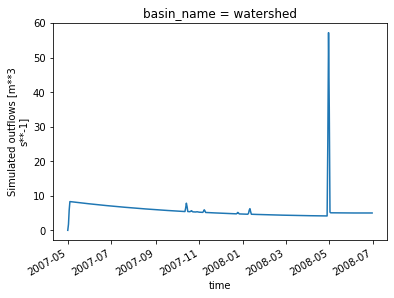

In [22]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

hydrograph.q_sim.plot()

In [ ]:
print("Max: ", hydrograph.q_sim.max())
print("Mean: ", hydrograph.q_sim.mean())
print("Monthly means: ", hydrograph.q_sim.groupby(hydrograph.time.dt.month).mean(dim='time'))